In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Add, Activation, LSTM, Reshape

In [2]:
# Load the dataset
data = load_diabetes()
X, y = data.data, data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
def dynamic_reshape(X):
    n_features = X.shape[1]
    factors = [(i, n_features // i) for i in range(1, n_features + 1) if n_features % i == 0]
    best_shape = min(factors, key=lambda x: abs(x[0] - x[1]))
    height, width = best_shape
    return X.reshape(-1, height, width, 1), (height, width, 1)

In [4]:
def build_random_forest():
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model.predict(X_test)

In [5]:
def build_mlp():
    inputs = Input(shape=(X_train_scaled.shape[1],))
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)
    return model.predict(X_test_scaled).flatten()

In [6]:
def build_dnn():
    inputs = Input(shape=(X_train_scaled.shape[1],))
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)
    return model.predict(X_test_scaled).flatten()

In [7]:
def build_cnn1d():
    X_train_cnn1d = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_test_cnn1d = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

    inputs = Input(shape=(X_train_cnn1d.shape[1], 1))
    x = Conv1D(32, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_cnn1d, y_train, epochs=100, batch_size=32, verbose=0)
    return model.predict(X_test_cnn1d).flatten()

In [8]:
def build_cnn2d():
    X_train_cnn2d, input_shape = dynamic_reshape(X_train_scaled)
    X_test_cnn2d, _ = dynamic_reshape(X_test_scaled)

    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    shortcut = x
    x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_cnn2d, y_train, epochs=100, batch_size=32, verbose=0)
    return model.predict(X_test_cnn2d).flatten()

In [9]:
def build_lstm():
    X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
    X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

    inputs = Input(shape=(1, X_train_scaled.shape[1]))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, verbose=0)
    return model.predict(X_test_lstm).flatten()

In [12]:
models = {
    'Random Forest': build_random_forest,
    'MLP': build_mlp,
    'DNN': build_dnn,
    'CNN1D': build_cnn1d,
    'CNN2D': build_cnn2d,
    'LSTM': build_lstm  # LSTM is not suitable for non-sequential data
}

results = {}

for model_name, model_func in models.items():
    print(f"Running predictions for {model_name}...")
    preds = model_func()
    mse = mean_squared_error(y_test, preds)
    results[model_name] = mse

results_df = pd.DataFrame(results.items(), columns=['Model', 'MSE'])
display(results_df)

Running predictions for Random Forest...
Running predictions for MLP...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Running predictions for DNN...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Running predictions for CNN1D...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Running predictions for CNN2D...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
Running predictions for LSTM...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


,Model,MSE
0,Random Forest,2952.010589
1,MLP,2844.355156
2,DNN,3073.190653
3,CNN1D,3263.938110
4,CNN2D,3430.258602
5,LSTM,16719.609854


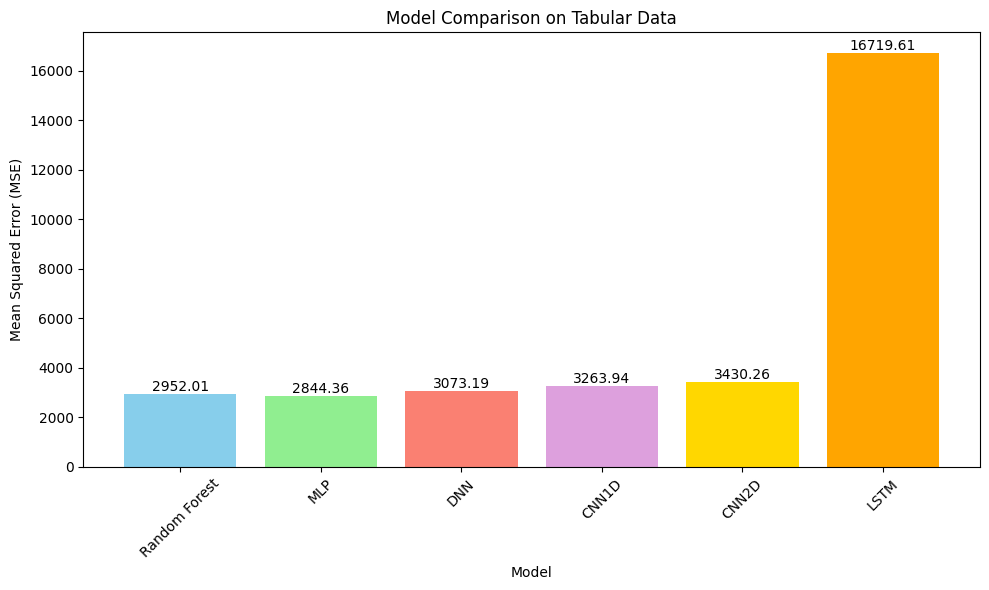

In [13]:
# Define distinct colors for each model
colors = ['skyblue', 'lightgreen', 'salmon', 'plum', 'gold', 'orange']

plt.figure(figsize=(10, 6))

# Create the bar plot
bars = plt.bar(results_df['Model'], results_df['MSE'], color=colors)

# Annotate each bar with its MSE value
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        height,                             # Y-coordinate (top of the bar)
        f'{height:.2f}',                    # MSE value formatted to 2 decimal places
        ha='center',                        # Horizontal alignment
        va='bottom'                         # Vertical alignment
    )

plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Comparison on Tabular Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()